## 1. Import Python libraries

In [ ]:
from pathlib import Path
from IPython.display import display
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

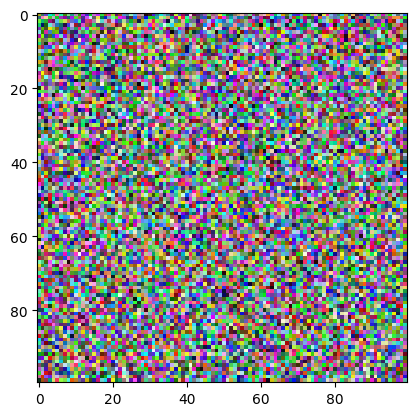

In [2]:
# generate test data
test_data = np.random.beta(1,1, size=(100,100,3))

#display test data
plt.imshow(test_data)
plt.show()

## 2. Opening images with PIL

The image size is: (256, 256)


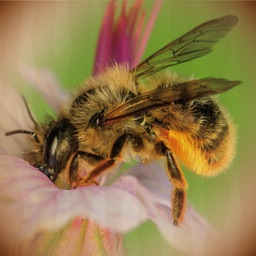

In [3]:
# open the image
img = Image.open(r'datasets/bee_2.jpg')

# Get the image size
img_size = img.size

print("The image size is: {}".format(img_size))

img

## 3. Image manipulation with PIL

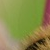

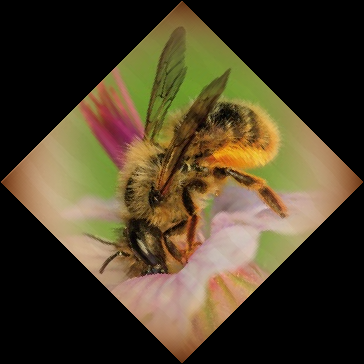

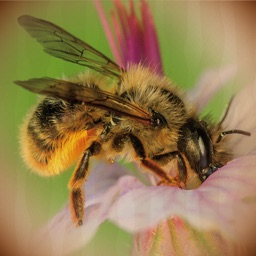

In [4]:
# Crop the image to 25, 25, 75, 75
img_cropped = img.crop((50, 50, 100, 100))
display(img_cropped)

# rotate the image by 45 degrees
img_rotated = img.rotate(45,expand=25)
display(img_rotated)

# flip the image left to right
img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
display(img_flipped)

## 4. Images as arrays of data

Our NumPy array has the shape: (256, 256, 3)


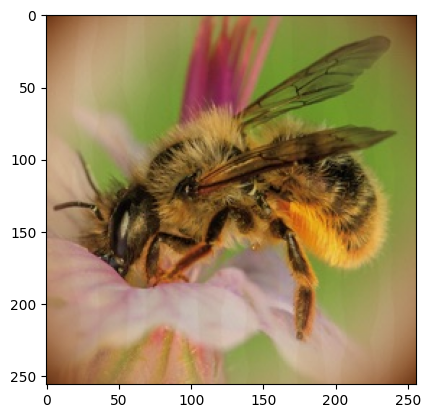

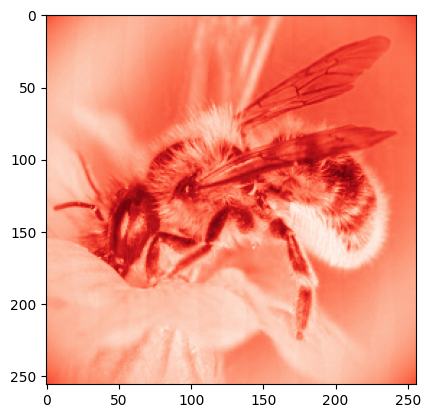

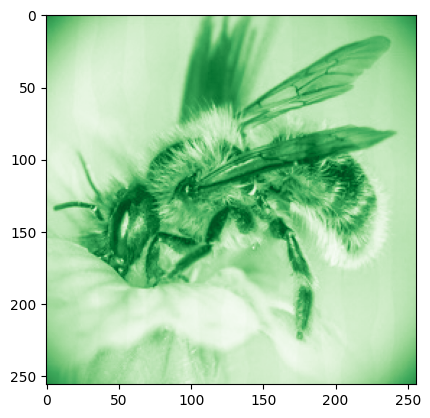

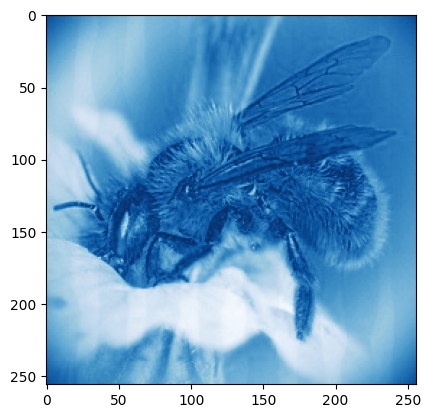

In [5]:
# Turn our image object into a NumPy array
img_data = np.array(img)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow` 
plt.imshow(img_data)
plt.show()

# plot the red channel
plt.imshow(img_data[:,:,0], cmap=plt.cm.Reds_r)
plt.show()

# plot the green channel
plt.imshow(img_data[:,:,1], cmap=plt.cm.Greens_r)
plt.show()

# plot the blue channel
plt.imshow(img_data[:,:,2], cmap=plt.cm.Blues_r)
plt.show()

## 5. Explore the color channels

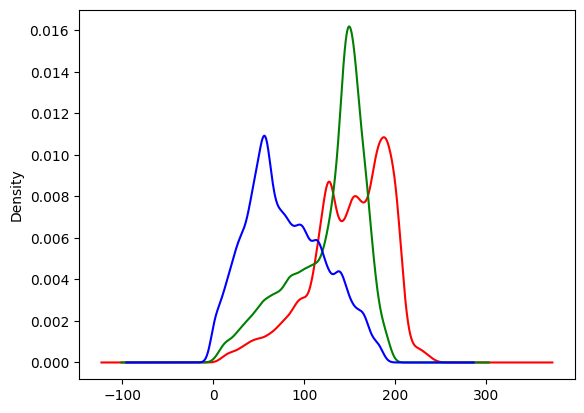

In [6]:
def plot_kde(channel, color):
    """ Plots a kernel density estimate for the given data.
        
        `channel` must be a 2d array
        `color` must be a color string, e.g. 'r', 'g', or 'b'
    """
    data = channel.flatten()
    return pd.Series(data).plot.density(c=color)

# create the list of channels
channels = ['r', 'g', 'b']
    
def plot_rgb(image_data):
    # use enumerate to loop over colors and indexes
    for ix, color in enumerate(channels):
        plot_kde(img_data[:, :, ix], color)
    
    plt.show()
    
plot_rgb(img_data)

## 6. Honey bees and bumble bees (i)

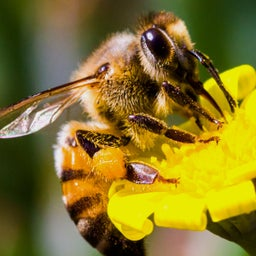

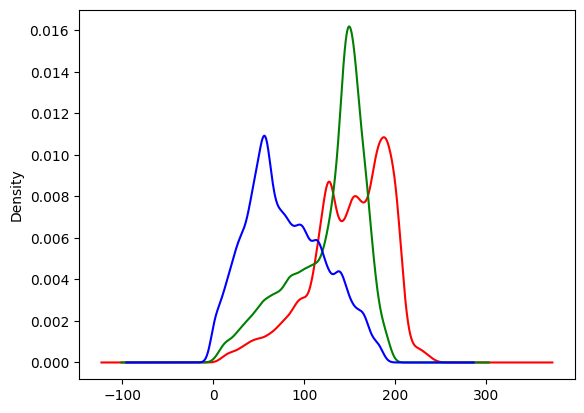

In [7]:
# load bee_12.jpg as honey
honey = Image.open('datasets/bee_12.jpg')

# display the honey bee image
display(honey)

# NumPy array of the honey bee image data
honey_data = np.array(honey)

# plot the rgb densities for the honey bee image
plot_rgb(honey_data)

## 7. Honey bees and bumble bees (ii)

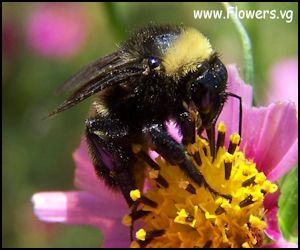

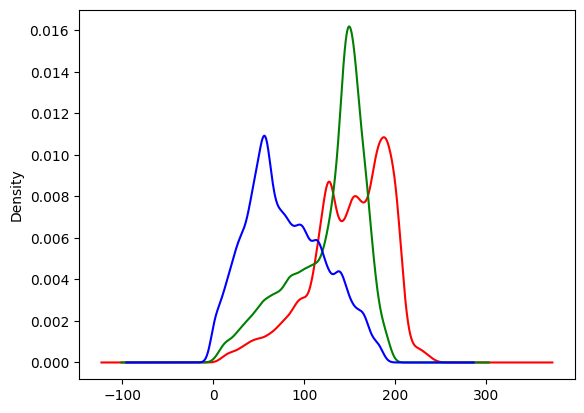

In [8]:
# load bee_3.jpg as bumble
bumble = Image.open('datasets/bee_3.jpg')

# display the bumble bee image
display(bumble)

# NumPy array of the bumble bee image data
bumble_data = np.array(bumble)

# plot the rgb densities for the bumble bee image
plot_rgb(bumble_data)

## 8. Simplify, simplify, simplify

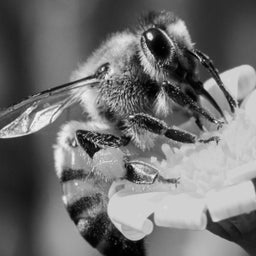

Our NumPy array has the shape: (256, 256)


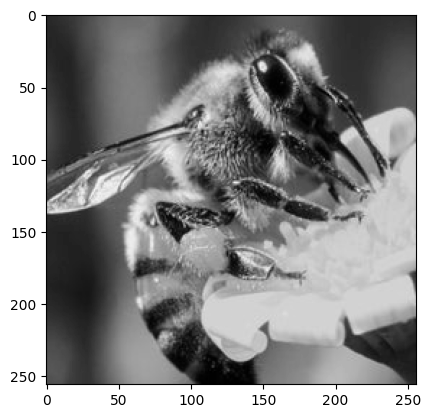

<Axes: ylabel='Density'>

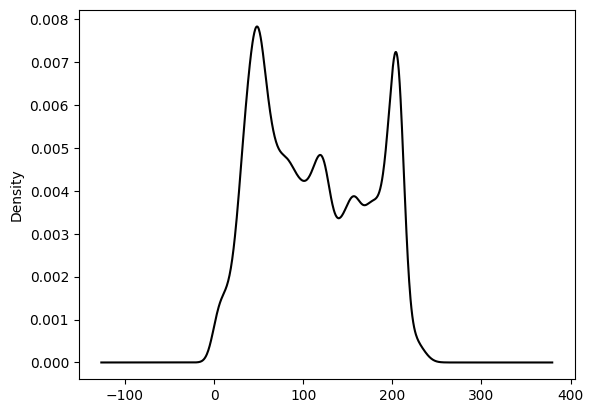

In [9]:
# convert honey to grayscale
honey_bw = honey.convert("L")
display(honey_bw)

# convert the image to a NumPy array
honey_bw_arr = np.array(honey_bw)

# get the shape of the resulting array
honey_bw_arr_shape = honey_bw_arr.shape
print("Our NumPy array has the shape: {}".format(honey_bw_arr_shape))

# plot the array using matplotlib
plt.imshow(honey_bw_arr, cmap=plt.cm.gray)
plt.show()

# plot the kde of the new black and white array
plot_kde(honey_bw_arr, 'k')

## Part 2 - Building a Model

In [12]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

## 1. Display image of each bee type

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


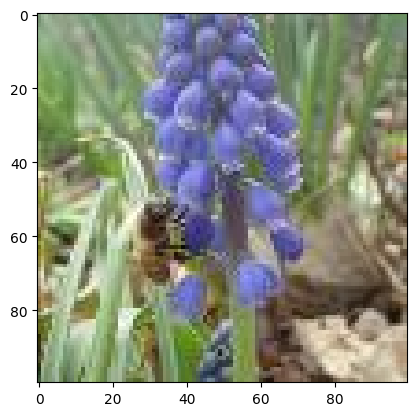

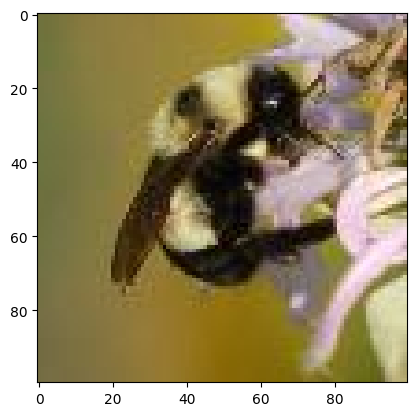

In [14]:
# load the labels using pandas
labels = pd.read_csv("datasets/labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head())

def get_image(row_id, root="datasets/images/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[5]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[5]

# show the corresponding image of a Bombus
plt.imshow(get_image(bombus_row))
plt.show()

## 2. Image manipulation with rgb2grey

Color bombus image has shape:  (100, 100, 3)
Greyscale bombus image has shape:  (100, 100)


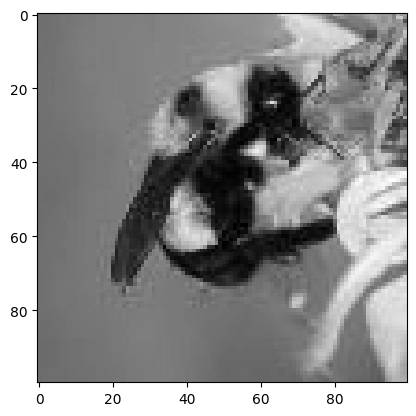

In [16]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

# print the shape of the bombus image
print('Color bombus image has shape: ', bombus.shape)

# convert the bombus image to greyscale
grey_bombus = rgb2gray(bombus)

# show the greyscale image
plt.imshow(grey_bombus, cmap=mpl.cm.gray)

# greyscale bombus image only has one channel
print('Greyscale bombus image has shape: ', grey_bombus.shape)

## 3. Histogram of oriented gradients

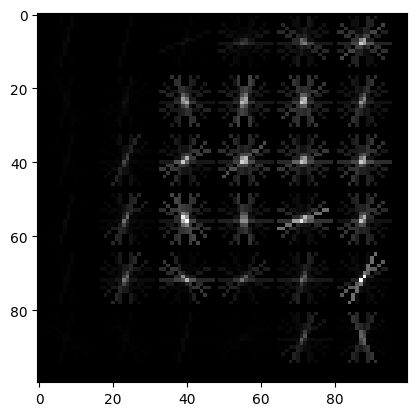

In [17]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a grey colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

## 4. Create image features and flatten into a single row

In [19]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2gray(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack([color_features, hog_features])
    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features
bombus_features.shape

(31296,)

## 5. Loop over images to preprocess

In [20]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

## 6. Scale feature matrix + PCA

In [21]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = pca.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

Feature matrix shape is:  (500, 31296)
PCA matrix shape is:  (500, 500)


## 7. Split into train and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1.0    175
0.0    175
Name: count, dtype: int64

## 8. Train Model

In [23]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

## 9. Score model

In [24]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.68


## 10. ROC curve + AUC

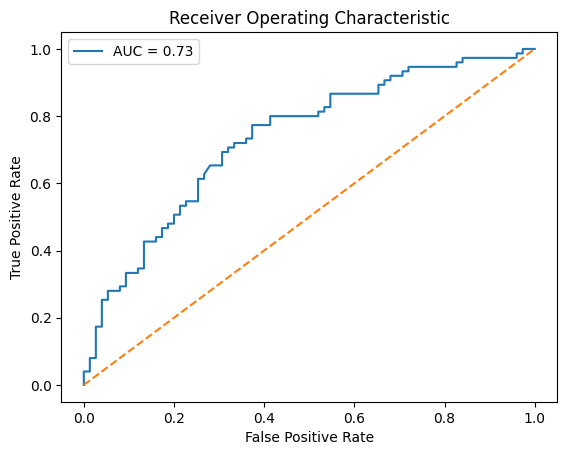

In [25]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');